# Propensity Scoring Using LSTM

In this notebook, we explore how sequencial-input models like LSTM can be used in customer analytics and personalization. More specifically, we focus on the follwoing questions:
* Can sequential-input models outperform traditional look-alike models with aggregared features? 
* How sequential-input models can simplify feature engineering? 
* How sequential-input models can improve explainability and customer beharior analysis?

The designs developed in this notebook can be applied a wide range of problems such purhase propensity scoring, churn prediction, price sensitivity analysis, and lead scoring. 

## Data
We use a small dataset created based on statistics from a digital media company that sells services on a subscription basis (see `datasets.md/KKBox` dataset). Files are located in the ``tensor-house-data`` repositoty under `/promotions/media-dataset` 

* The dataset includes about 9,000 customer profiles with the daily service usage data. 
* Each profile is attributed with an *outcome* label. 
* The *outcome* label equals to one for users who took a specific action of interest (positive outcome), and zero otherwise (negative outcome).
* Half of the profiles have positive outcomes and the other half have negative outcomes.  
* The dataset includes two tables:
    * Users:
        * uid - user ID
        * location - location ID (city or region)
        * age - user age
        * gender - user gender
        * registration_channel - ID of the channel though which the user had been acquired
        * registration_date - registration date
        * outcome - binary flag that indicates whether the user took a specific action or not
    * Usage logs:
        * uid - user ID
        * date - activity record date (activity is recorded on a daily basis)
        * views - how many media items user has consumed
        * items - how many media items user has interacted with
        * duration - how much time user spent
        * previews - how many items user has previewed 

In [110]:
#
# Import modules
#
import pandas as pd
import numpy as np
import lightgbm as lgb
from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import platform

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate
from tensorflow.keras.layers import Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import backend as K
import keras_tuner as kt

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

print(f'Python {platform.python_version()} | TF {tf.__version__} | Keras {tf.keras.__version__}')

Python 3.10.2 | TF 2.8.0 | Keras 2.8.0


In [44]:
#
# Visualization and helper functions
#
    
def plot_roc(y_test, y_hat_prob):
    plt.figure(figsize=(8, 8))
    false_positive_rate, recall, thresholds = roc_curve(y_test, y_hat_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'r', label = 'AUC = %0.3f' % roc_auc)
    plt.fill_between(false_positive_rate, recall, color='r', alpha=0.025)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1 - Specificity)')
    plt.show()
    
def plot_confusion_matrix(y, y_hat_prob, labels):
    y_hat = np.where(y_hat_prob > 0.5, 1, 0) # probability to 0-1 binary
    cm = confusion_matrix(y, y_hat)
    accuracy = accuracy_score(y, y_hat)
    plt.figure(figsize=(4, 4));
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, 
                annot = True, cbar=False, fmt='d', annot_kws={'size': 16}, 
                cmap="Wistia", vmin = 0.2);
    plt.title(f'Confusion Matrix\n({len(y)} samples, accuracy {accuracy:.3f})')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
def print_df(df, col_width = 10, rows = 10, max_cols = 10):
    def short_srt(x):
        return x if len(x) < col_width else x[:col_width-3] + "..."
    df_short = df.head(rows).applymap(lambda x: short_srt(str(x)))
    
    if len(df_short.columns) > max_cols:
        df_short = df_short.iloc[:, 0:max_cols-1]
        df_short['...'] = '...'
    
    print(tabulate(df_short, headers='keys', tablefmt='psql'))
    print(f'{len(df)} rows x {len(df.columns)} columns')
    
def normalize(df, columns):
    for c in columns:
        df.loc[:, c] = (df[c] - df[c].min()) / (df[c].max() - df[c].min())

# Data Loading

In [17]:
#
# Import data
#
data_path = '../../tensor-house-data/promotions/media-subsription/'
df_users = pd.read_csv(data_path + 'users.csv.zip', compression='zip', index_col='uid', parse_dates=['reg_date'])
df_logs = pd.read_csv(data_path + 'usage_logs.csv.zip', compression='zip', index_col='uid', parse_dates=['date']).drop(columns=['items'])

print_df(df_users)
print_df(df_logs)
n_positives = df_users['outcome'].sum()
print(f'Profiles with positive oucomes: {n_positives} ({n_positives/len(df_users):.2%})')
print(f'Users without events: {len(set(df_users.index).difference(set(df_logs.index)))}')

+-------+------------+-------+----------+---------------+---------------------+-----------+
|   uid |   location |   age | gender   |   reg_channel | reg_date            |   outcome |
|-------+------------+-------+----------+---------------+---------------------+-----------|
|     0 |         15 |    17 | female   |             3 | 2014-10-21 00:00:00 |         1 |
|     1 |         13 |    40 | female   |             9 | 2006-05-26 00:00:00 |         0 |
|     2 |         14 |    23 | male     |             9 | 2007-03-25 00:00:00 |         1 |
|     3 |          1 |    19 | female   |             3 | 2014-11-02 00:00:00 |         1 |
|     4 |          1 |     0 | nan      |             9 | 2014-11-08 00:00:00 |         1 |
|     5 |         21 |    21 | male     |             9 | 2007-10-12 00:00:00 |         1 |
|     6 |          1 |     0 | nan      |             7 | 2014-04-16 00:00:00 |         1 |
|     7 |          5 |     0 | nan      |             9 | 2013-02-06 00:00:00 | 

In [97]:
#
# Basic feature engineering
#
profiles = df_users.join(df_logs.drop(columns='date').groupby('uid').agg('sum'), on='uid')
profiles['reg_days'] = (profiles['reg_date'].max() - profiles['reg_date']).dt.days
profiles = pd.get_dummies(profiles, columns=['gender'])
profiles.drop(columns=['reg_date'], inplace=True)
print_df(profiles)

+-------+------------+-------+---------------+-----------+---------+------------+------------------+---------------+------------+-------+
|   uid |   location |   age |   reg_channel |   outcome |   views |   previews |         duration |   time_bucket |   reg_days | ...   |
|-------+------------+-------+---------------+-----------+---------+------------+------------------+---------------+------------+-------|
|     0 |         15 |    17 |             3 |         1 |    2677 |       4600 |  86544           |        -21397 |        856 | ...   |
|     1 |         13 |    40 |             9 |         0 |   23010 |       7136 | 635905           |        -42349 |       3926 | ...   |
|     2 |         14 |    23 |             9 |         1 |   52578 |       5000 |      1.32565e+06 |        -43688 |       3623 | ...   |
|     3 |          1 |    19 |             3 |         1 |    5422 |       2072 | 145091           |        -28555 |        844 | ...   |
|     4 |          1 |     0 |    

# Step 1: Baseline Using GBDT

We start with building baseline models. The first baseline is a typical look-alike model that is based on gradient boosted decison trees (LightGBM) and aggregated features.  

In [56]:
#
# Train test split
#
x, y = profiles.drop(columns='outcome'), profiles['outcome']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [58]:
train_data = lgb.Dataset(x_train, label=y_train)

# Model hyper-parameters
params = {'max_depth' : -1,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'num_class' : 1,
          'metric' : 'binary_error',
          'verbosity' : 0
          }

# Parameters to optimize
gridParams = {
    'learning_rate': [0.02, 0.05, 0.07],
    'n_estimators': [8, 16, 32, 64, 128],
    'num_leaves': [20, 24, 28],
    'colsample_bytree' : [0.60, 0.65]
    }

# Create the classifier
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'])

mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)

# Search for optimal parameters
grid.fit(x_train, y_train)

# Print the best parameters values
print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
params['num_leaves'] = grid.best_params_['num_leaves']
params['n_estimators'] = grid.best_params_['n_estimators']

print(f'Fitting with params: {params}')

# Train the model on the selected parameters
lgbm = lgb.train(params,
                 train_data,
                 num_boost_round=200,
                 verbose_eval= 4)

Fitting 4 folds for each of 90 candidates, totalling 360 fits
Best params: {'colsample_bytree': 0.65, 'learning_rate': 0.05, 'n_estimators': 64, 'num_leaves': 24}
Best score: 0.6989967440225928
Fitting with params: {'max_depth': -1, 'num_leaves': 24, 'learning_rate': 0.05, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.65, 'num_class': 1, 'metric': 'binary_error', 'verbosity': 0, 'n_estimators': 64}
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


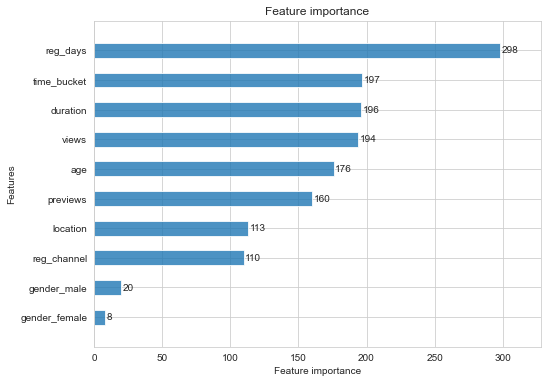

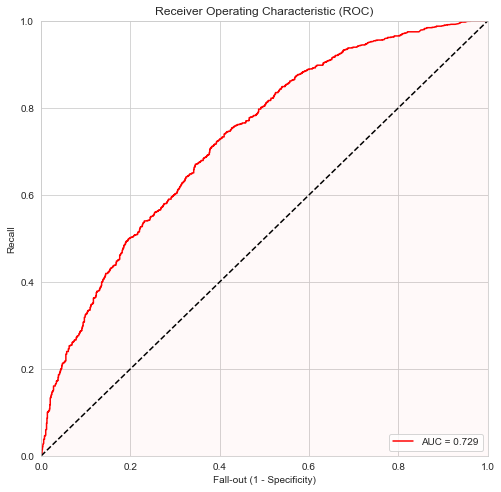

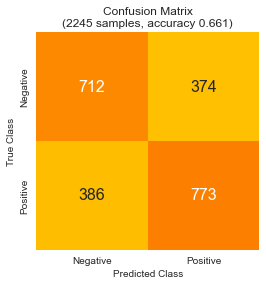

In [59]:
# 
# Plot accuracy measures and diagnostic information
#

# Predict on test set
predictions_lgbm_prob = lgbm.predict(x_test)

# Plot feature importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split',
                    height=0.5, color='#1f77b4', alpha=0.8, figsize=(8, 6))

# plot ROC
plot_roc(y_test, predictions_lgbm_prob)

# plot confusion matrix
plot_confusion_matrix(y_test, predictions_lgbm_prob, ['Negative', 'Positive'])

# Step 2: Baseline Using Dense Network

In [89]:
#
# Feature engineerign for Keras
#
x, y = profiles[['location', 'age', 'reg_channel', 'reg_days', 'gender_female', 'gender_male']], profiles['outcome']
x = pd.get_dummies(x, columns=['reg_channel'])
x = pd.get_dummies(x, columns=['location'])

#
# Column-wise normalization
#
normalize(x, x.columns)

print_df(x)

+-------+------------+------------+-----------------+---------------+-----------------+-----------------+-----------------+-----------------+------------------+-------+
|   uid | age        | reg_days   |   gender_female |   gender_male |   reg_channel_3 |   reg_channel_4 |   reg_channel_7 |   reg_channel_9 |   reg_channel_13 | ...   |
|-------+------------+------------+-----------------+---------------+-----------------+-----------------+-----------------+-----------------+------------------+-------|
|     0 | 0.07033... | 0.18147... |               1 |             0 |               1 |               0 |               0 |               0 |                0 | ...   |
|     1 | 0.09730... | 0.83230... |               1 |             0 |               0 |               0 |               0 |               1 |                0 | ...   |
|     2 | 0.07737... | 0.76807... |               0 |             1 |               0 |               0 |               0 |               1 |              

Trial 5 Complete [00h 00m 04s]
val_accuracy: 0.6628062129020691

Best val_accuracy So Far: 0.6645879745483398
Total elapsed time: 00h 00m 23s
INFO:tensorflow:Oracle triggered exit
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 8)                 248       
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params:

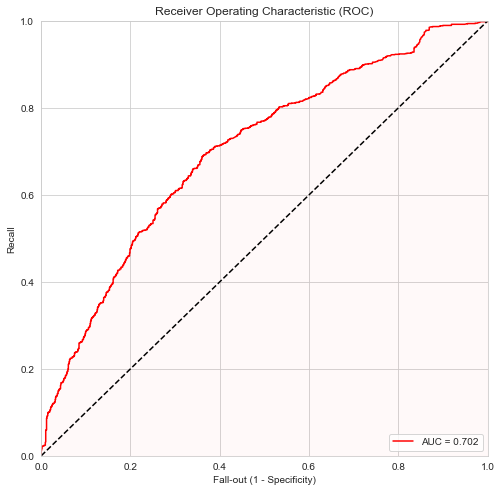

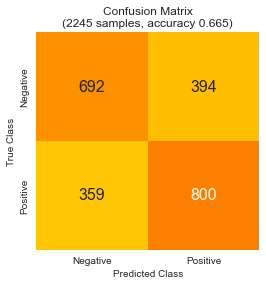

In [95]:
#
# Train test split
#
x_train, x_test, y_train, y_test = train_test_split(x.to_numpy(), y, test_size=0.25, random_state=42)

#
# Model specification
#
def build_model(hp):
    dense_1_dims = hp.Choice('dense_1_dims', [8, 16, 32])
    dense_2_dims = hp.Choice('dense_2_dims', [8, 16, 32])
    dense_3_dims = hp.Choice('dense_3_dims', [8, 16, 32])
    
    input_agg = Input(shape=(x.shape[1]))
    dense_1 = Dense(dense_1_dims, activation='relu')(input_agg)
    dense_2 = Dense(dense_2_dims, activation='relu')(dense_1)
    dense_3 = Dense(dense_3_dims, activation='relu')(dense_2)
    prob_outcome = Dense(1, activation='sigmoid')(dense_3)
    model_dense = Model(inputs=input_agg, outputs=prob_outcome)
    
    model_dense.compile(optimizer='rmsprop', 
                        loss='binary_crossentropy', 
                        metrics=['accuracy']) 
    
    return model_dense

#
# Hyperparameters optimization
#
tuner = kt.RandomSearch(build_model, objective='val_accuracy', overwrite = True, max_trials=5)
tuner.search(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_test, y_test))
best_hp = tuner.get_best_hyperparameters()[0]
model_dense = tuner.get_best_models()[0]
model_dense.summary()

#
# Model training
#
score = model_dense.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

#
# Model evaluation
#
predictions_dense_prob = model_dense.predict(x_test)
plot_roc(y_test, predictions_dense_prob)
plot_confusion_matrix(y_test, predictions_dense_prob, ['Negative', 'Positive'])

# Step 3: LSTM Model

The second step is to build an LSTM model using Keras. We use a model with two inputs:
* One input is a 3D tensor that consist of ordered usage histories aggregated by weeks. This is input is processed by LSTM.
* The second input is the user profile. This input is proceed by a dense layer.

Output of the two submodels are concatenated and processed by several dense layers.

In [98]:
#
# Feature engineering for Keras
#
x, y = profiles[['location', 'age', 'reg_channel', 'reg_days', 'gender_female', 'gender_male']], profiles['outcome']
x = pd.get_dummies(x, columns=['reg_channel'])
x = pd.get_dummies(x, columns=['location'])

#
# Column-wise normalization
#
normalize(x, x.columns)

print_df(x)

+-------+------------+------------+-----------------+---------------+-----------------+-----------------+-----------------+-----------------+------------------+-------+
|   uid | age        | reg_days   |   gender_female |   gender_male |   reg_channel_3 |   reg_channel_4 |   reg_channel_7 |   reg_channel_9 |   reg_channel_13 | ...   |
|-------+------------+------------+-----------------+---------------+-----------------+-----------------+-----------------+-----------------+------------------+-------|
|     0 | 0.07033... | 0.18147... |               1 |             0 |               1 |               0 |               0 |               0 |                0 | ...   |
|     1 | 0.09730... | 0.83230... |               1 |             0 |               0 |               0 |               0 |               1 |                0 | ...   |
|     2 | 0.07737... | 0.76807... |               0 |             1 |               0 |               0 |               0 |               1 |              

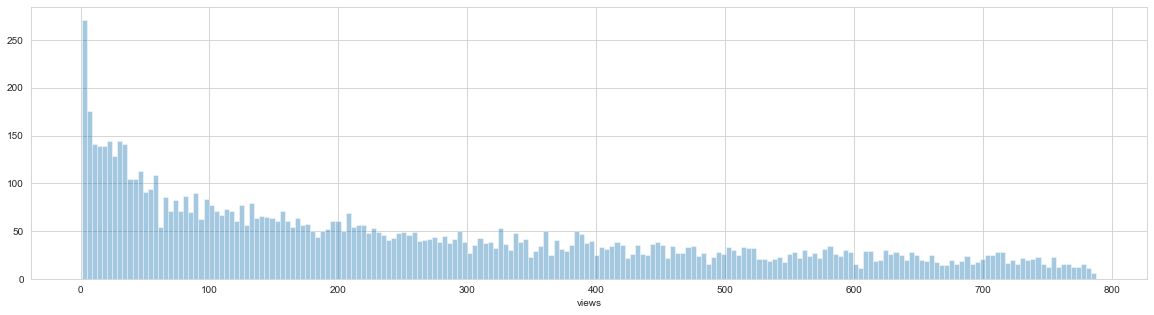

In [99]:
#
# plot how the number of activity records per user is distributed 
#
plt.figure(figsize=(20, 5));
sns.distplot(df_logs.groupby('uid').count()['views'], bins = 200, kde = False);

In [ ]:
#
# aggregate daily activity records into buckets (e.g. weekly) and normalize
#
df_logs['time_bucket'] = -((df_logs['date'].max() - df_logs['date']).dt.days / 7).astype(int)
df_logs_weekly = df_logs.groupby(['uid', 'time_bucket']).sum()
normalize(df_logs_weekly, df_logs_weekly.columns)
print_df(df_logs_weekly)

+-----------+------------+------------+------------+
|           | views      | previews   | duration   |
|-----------+------------+------------+------------|
| (0, -104) | 0.02357... | 0.05372... | 0.15709... |
| (0, -103) | 0.01817... | 0.05228... | 0.11822... |
| (0, -102) | 0.01799... | 0.05314... | 0.12069... |
| (0, -101) | 0.00971... | 0.05458... | 0.07107... |
| (0, -100) | 0.00503... | 0.04108... | 0.04295... |
| (0, -99)  | 0.00233... | 0.01407... | 0.01507... |
| (0, -98)  | 0.00503... | 0.02872... | 0.05008... |
| (0, -97)  | 0.01421... | 0.02729... | 0.09132... |
| (0, -96)  | 0.00143... | 0.00861... | 0.01189... |
| (0, -95)  | 0.01097... | 0.02212... | 0.06178... |
+-----------+------------+------------+------------+
507445 rows x 3 columns


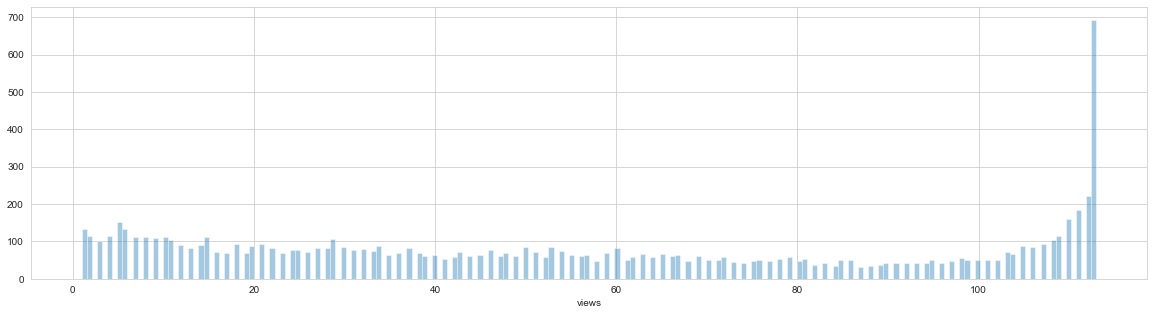

In [101]:
#
# plot how the number of weekly activity records per user is distributed 
#
plt.figure(figsize=(20, 5));
sns.distplot(df_logs_weekly.groupby('uid').count()['views'], bins = 200, kde = False);

In [105]:
#
# Feature engineering for Keras: 3D tensor for LSTM (n_users x events_per_user x n_features_per_event)
#
a3d = df_logs_weekly.sort_values(['uid', 'time_bucket']).groupby('uid').apply(pd.DataFrame.to_numpy)
n_users = len(df_users)
events_per_user = df_logs_weekly.groupby('uid').count()['views'].max()
n_features = len(df_logs_weekly.columns)
x3d = np.zeros((n_users, events_per_user, n_features))
for uid in df_users.index:
    if uid in df_logs.index:
        n_events = min(events_per_user, len(a3d[uid]))
        x3d[uid, -n_events:, :] = a3d[uid][-n_events:, :]
        
print(f'Input tensor shapes: x3d {x3d.shape}, x {x.shape}, y {y.shape}')

#
# Train-test split
#
x3d_train, x3d_test, x_train, x_test, y_train, y_test = train_test_split(x3d, x, y, test_size = 0.25, random_state = 1)

Input tensor shapes: x3d (8979, 113, 3), x (8979, 30), y (8979,)


Epoch 1/10
421/421 [==============================] - 12s 25ms/step - loss: 0.6386 - accuracy: 0.6482 - val_loss: 0.6262 - val_accuracy: 0.6663
Epoch 2/10
421/421 [==============================] - 10s 24ms/step - loss: 0.6137 - accuracy: 0.6723 - val_loss: 0.6046 - val_accuracy: 0.6834
Epoch 3/10
421/421 [==============================] - 9s 22ms/step - loss: 0.6040 - accuracy: 0.6816 - val_loss: 0.5937 - val_accuracy: 0.6892
Epoch 4/10
421/421 [==============================] - 9s 21ms/step - loss: 0.5913 - accuracy: 0.6953 - val_loss: 0.5777 - val_accuracy: 0.7034
Epoch 5/10
421/421 [==============================] - 9s 22ms/step - loss: 0.5771 - accuracy: 0.6990 - val_loss: 0.5621 - val_accuracy: 0.7167
Epoch 6/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5656 - accuracy: 0.7100 - val_loss: 0.5557 - val_accuracy: 0.7186
Epoch 7/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5598 - accuracy: 0.7158 - val_loss: 0.5502 - val_accuracy: 0.

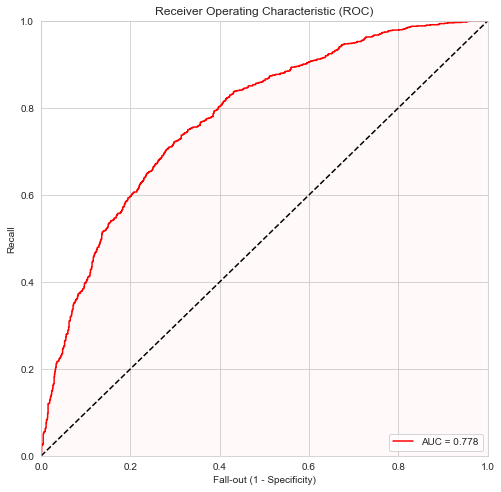

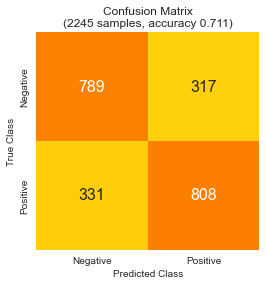

In [112]:
#
# Model specification
#

# Inputs
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
lstm_out = LSTM(8, input_shape=(events_per_user, n_features))(input_logs)
lstm_tower = Model(inputs=input_logs, outputs=lstm_out)

# User profile tower
profile_out = Dense(16, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top_1 = Dense(32, activation='relu')(combined)
dense_top_2 = Dense(16, activation='relu')(dense_top_1)
dense_top_3 = Dense(8, activation='relu')(dense_top_2)
prob_outcome = Dense(1, activation='sigmoid')(dense_top_3)
model_lstm = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_outcome)

#
# Model training
#
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model_lstm.fit([x3d_train, x_train], y_train, batch_size=16, epochs=10, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model_lstm.evaluate([x3d_test, x_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

#
# Model evaluation
#
predictions_lstm_prob = model_lstm.predict([x3d_test, x_test])
plot_roc(y_test, predictions_lstm_prob)
plot_confusion_matrix(y_test, predictions_lstm_prob, ['Negative', 'Positive'])

We can make the following conclusions :
* LSTM easily outperforms the look-alike baseline. It is possible to improve the LightGBM baseline using more sophisticated feature engineering and tuning, but at the cost of extra effort.
* Feature engineering is somewhat simpler becasue we use event-level attributes, not profile-level aggregates.

# Step 4: LSTM with Attention

Finally, we build and evaluate the LSTM with attention design.

In [108]:
#
# Train-test sets x3d_train, x3d_test, x_train, x_test, y_train, y_test are the same as for LSTM
#

Epoch 1/10
421/421 [==============================] - 12s 24ms/step - loss: 0.6484 - accuracy: 0.6341 - val_loss: 0.6219 - val_accuracy: 0.6663
Epoch 2/10
421/421 [==============================] - 10s 24ms/step - loss: 0.6182 - accuracy: 0.6699 - val_loss: 0.6113 - val_accuracy: 0.6718
Epoch 3/10
421/421 [==============================] - 11s 25ms/step - loss: 0.6126 - accuracy: 0.6743 - val_loss: 0.6134 - val_accuracy: 0.6732
Epoch 4/10
421/421 [==============================] - 10s 24ms/step - loss: 0.6114 - accuracy: 0.6734 - val_loss: 0.6139 - val_accuracy: 0.6761
Epoch 5/10
421/421 [==============================] - 10s 24ms/step - loss: 0.6098 - accuracy: 0.6720 - val_loss: 0.6053 - val_accuracy: 0.6754
Epoch 6/10
421/421 [==============================] - 10s 24ms/step - loss: 0.6074 - accuracy: 0.6775 - val_loss: 0.6069 - val_accuracy: 0.6781
Epoch 7/10
421/421 [==============================] - 9s 22ms/step - loss: 0.6063 - accuracy: 0.6782 - val_loss: 0.6016 - val_accuracy: 

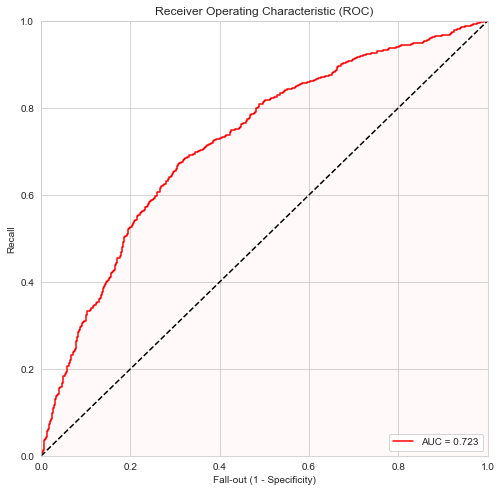

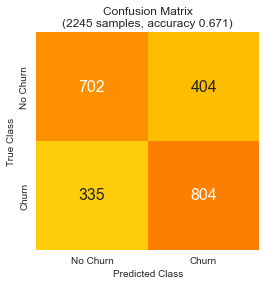

In [111]:
#
# Model parameters
#
hidden_units = 8

#
# Model specification
#
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
activations = LSTM(hidden_units, return_sequences=True)(input_logs)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_weigths')(attention)
attention = RepeatVector(hidden_units * 1)(attention)
attention = Permute([2, 1])(attention)

weighted_activations = Multiply()([activations, attention])
weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)

lstm_tower = Model(inputs=input_logs, outputs=weighted_activations)

# User profile tower
profile_out = Dense(16, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top = Dense(32, activation='relu')(combined)
prob_outcome = Dense(1, activation='sigmoid')(dense_top)
model_lstm_attn = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_outcome)

#
# Model training
#
model_lstm_attn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model_lstm_attn.fit([x3d_train, x_train], y_train, batch_size=16, epochs=10, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model_lstm_attn.evaluate([x3d_test, x_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

#
# Model evaluation
#
predictions_lstm_a_prob = model_lstm_attn.predict([x3d_test, x_test])
plot_roc(y_test, predictions_lstm_a_prob)
plot_confusion_matrix(y_test, predictions_lstm_a_prob, ['Negative', 'Positive'])

In [64]:
#
# Attention weights analysis
#
attention_model = Model(inputs=model_lstm_attn.input, outputs=model_lstm_attn.get_layer('attention_weigths').output)
a = attention_model.predict([x3d_test, x_test])
print(f'Attention weights matrix: {a.shape[0]} users x {a.shape[1]} weights')

Attention weights matrix: 2245 users x 113 weights


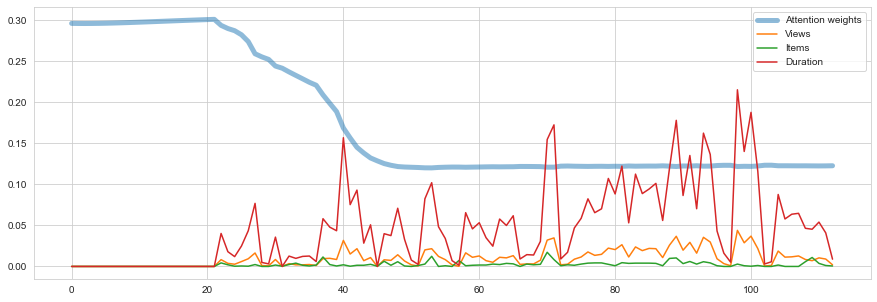

In [65]:
uid = 30
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(20 * a[uid, :], label='Attention weights', linewidth=5, alpha=0.5)
for i, column in zip(range(n_features), ['Views', 'Items', 'Duration', 'Previews']):
    ax.plot(x3d_test[uid][:, i], label=column)
ax.legend();

The above plot illustrates how the model puts the emphasis on the beginning of the customer journey. We can use attention weights in several ways:
* We can analyze the behavior drivers inspecting which event have high contribution.
* We can cluster customers in the space of weight vectors to find typical patterns that result in a specific outcome.